In [1]:
import torch as T
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pytorch_lightning as pl
from src.utils.functions import create_sequences
from torch.utils.data import DataLoader
from src.dataset import PecanDataset
from src.pecan_dataport.participant_preprocessing import PecanParticipantPreProcessing
from src.regressors.rnn_regressor import ConsumptionRNNRegressor
from sklearn.preprocessing import MinMaxScaler


In [2]:
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [3]:
ckpt = 'etc/ckpts/participants/661_test_30_pca/sigmoid/RNN/best/best-RNN-chpkt-pecanstreet-participant-id-661_test_30_pca_epoch=192-val_loss=0.00000.ckpt'
device = T.device('cuda' if T.cuda.is_available() else 'cpu')

In [4]:
pecan_dataset = PecanParticipantPreProcessing('661_test_30_pca', 'data/participants_data/1min',
                                                   60, task='test')
default_scaler = pecan_dataset.scaler

[!] - Trainable dataframe shape - (129086, 18)
[*] Train dataframe shape: (90360, 18)
[*] Validation dataframe shape: (25817, 18)
[*] Test dataframe shape: (12909, 18)


100%|█████████████████████████████████████████████████████████████████████████| 12849/12849 [00:00<00:00, 13269.63it/s]

[!] Val sequence shape: (60, 18)
[!] Test sequence shape: (60, 18)


# Aumentar o test dataset com as features originais

In [5]:
original_data = pd.read_csv("data/participants_data/1min/features/661_features.csv", sep=',')
model_features = pd.read_csv("data/participants_data/1min/features/661_test_30_pca_features.csv", sep=',')


In [6]:
model_features

,generation,time_hour,time_minute,month,day_of_week,day,week_of_year,consumption,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,cloudcover,humidity,precipMM,visibility,winddirDegree
0,0.000,0,0,1,0,1,1,0.691,-4,0.0,10.0,1,97,93,57,0.0,10,9
1,0.000,0,1,1,0,1,1,0.689,-4,0.0,10.0,1,97,93,57,0.0,10,9
2,0.000,0,2,1,0,1,1,0.688,-4,0.0,10.0,1,97,93,57,0.0,10,9
3,0.000,0,3,1,0,1,1,0.688,-4,0.0,10.0,1,97,93,57,0.0,10,9
4,0.000,0,4,1,0,1,1,0.687,-4,0.0,10.0,1,97,93,57,0.0,10,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129081,3.568,16,21,3,5,31,13,-2.304,13,0.0,11.6,6,96,0,61,0.0,10,178
129082,3.517,16,22,3,5,31,13,-2.255,13,0.0,11.6,6,96,0,61,0.0,10,178
129083,3.511,16,23,3,5,31,13,-2.256,13,0.0,11.6,6,96,0,61,0.0,10,178
129084,3.569,16,24,3,5,31,13,-2.328,13,0.0,11.6,6,96,0,61,0.0,10,178


## Pegas as colunas que são do PCA

In [7]:
original_data = original_data[model_features.columns.to_list()]
original_data

,generation,time_hour,time_minute,month,day_of_week,day,week_of_year,consumption,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,cloudcover,humidity,precipMM,visibility,winddirDegree
0,0.0,0,0,1,0,1,1,0.691,-4,0.0,10.0,1,97,93,57,0.0,10,9
1,0.0,0,1,1,0,1,1,0.689,-4,0.0,10.0,1,97,93,57,0.0,10,9
2,0.0,0,2,1,0,1,1,0.688,-4,0.0,10.0,1,97,93,57,0.0,10,9
3,0.0,0,3,1,0,1,1,0.688,-4,0.0,10.0,1,97,93,57,0.0,10,9
4,0.0,0,4,1,0,1,1,0.687,-4,0.0,10.0,1,97,93,57,0.0,10,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525525,0.0,23,55,12,0,31,1,1.754,5,0.0,10.1,3,36,5,74,0.0,10,218
525526,0.0,23,56,12,0,31,1,1.737,5,0.0,10.1,3,36,5,74,0.0,10,218
525527,0.0,23,57,12,0,31,1,1.736,5,0.0,10.1,3,36,5,74,0.0,10,218
525528,0.0,23,58,12,0,31,1,1.757,5,0.0,10.1,3,36,5,74,0.0,10,218


In [8]:
original_data = pd.DataFrame(pecan_dataset.scaler.transform(original_data), index=original_data.index,
                         columns=original_data.columns
)

In [9]:
#para pegar as última sequencia de previsões
test_df = pecan_dataset.test_df.copy()

test_df=test_df.append(original_data.iloc[129086:129151])
test_df.iloc[-61:]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,generation,time_hour,time_minute,month,day_of_week,day,week_of_year,consumption,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,cloudcover,humidity,precipMM,visibility,winddirDegree
129090,0.280498,0.391304,0.016949,1.0,0.666667,1.0,1.0,-0.780777,0.461538,-1.0,1.0,1.0,0.92,-1.0,0.012987,-1.0,1.0,-0.011111
129091,0.252903,0.391304,0.050847,1.0,0.666667,1.0,1.0,-0.773988,0.461538,-1.0,1.0,1.0,0.92,-1.0,0.012987,-1.0,1.0,-0.011111
129092,0.218576,0.391304,0.084746,1.0,0.666667,1.0,1.0,-0.765626,0.461538,-1.0,1.0,1.0,0.92,-1.0,0.012987,-1.0,1.0,-0.011111
129093,0.158338,0.391304,0.118644,1.0,0.666667,1.0,1.0,-0.751056,0.461538,-1.0,1.0,1.0,0.92,-1.0,0.012987,-1.0,1.0,-0.011111
129094,0.160693,0.391304,0.152542,1.0,0.666667,1.0,1.0,-0.751635,0.461538,-1.0,1.0,1.0,0.92,-1.0,0.012987,-1.0,1.0,-0.011111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129146,-0.218913,0.478261,-0.118644,1.0,0.666667,1.0,1.0,-0.637222,0.461538,-1.0,1.0,1.0,0.92,-1.0,0.142857,-1.0,1.0,-0.033333
129147,-0.201077,0.478261,-0.084746,1.0,0.666667,1.0,1.0,-0.644921,0.461538,-1.0,1.0,1.0,0.92,-1.0,0.142857,-1.0,1.0,-0.033333
129148,-0.221605,0.478261,-0.050847,1.0,0.666667,1.0,1.0,-0.645335,0.461538,-1.0,1.0,1.0,0.92,-1.0,0.142857,-1.0,1.0,-0.033333
129149,-0.228336,0.478261,-0.016949,1.0,0.666667,1.0,1.0,-0.640119,0.461538,-1.0,1.0,1.0,0.92,-1.0,0.142857,-1.0,1.0,-0.033333


# Previsão usando o novo dataset de test

In [10]:
test_prediction = test_df.copy()
test_sequence = create_sequences(test_prediction, 'consumption', 60)
test_dataModule = DataLoader(dataset=PecanDataset(test_sequence, device), batch_size=1, shuffle=False, num_workers=6, pin_memory=False)

100%|█████████████████████████████████████████████████████████████████████████| 12914/12914 [00:00<00:00, 14089.83it/s]


In [11]:
model = ConsumptionRNNRegressor.load_from_checkpoint(checkpoint_path=ckpt,
                                                     strict=False,
                                                     scaler=pecan_dataset.scaler,
                                                     device=device,
                                                     n_features=pecan_dataset.get_n_features(),
                                                     lr=1e-5,
                                                     n_hidden=256,
                                                     n_layers=3,
                                                     dropout=0.3,
                                                     activation_function='sigmoid')
model.freeze()
model

ConsumptionRNNRegressor(
  (explained_var): ExplainedVariance()
  (MAE): MeanAbsoluteError()
  (MAPE): MeanAbsolutePercentageError()
  (SMAPE): SymmetricMeanAbsolutePercentageError()
  (WMAPE): WeightedMeanAbsolutePercentageError()
  (MSE): MeanSquaredError()
  (RMSE): MeanSquaredError()
  (MSLE): MeanSquaredLogError()
  (pearson_coef): PearsonCorrCoef()
  (tweedie_dev): TweedieDevianceScore()
  (model): RNNModel(
    (rnn): RNN(18, 256, num_layers=3, batch_first=True, dropout=0.3)
    (fc1): Linear(in_features=256, out_features=512, bias=True)
    (regressor): Linear(in_features=512, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)

In [12]:
trainer = pl.Trainer(
    gpus=1,
    progress_bar_refresh_rate=60
)
trainer.test(model, test_dataModule)

`max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
Setting `Trainer(progress_bar_refresh_rate=60)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/MAE            0.06216607987880707
        test/MAPE           0.30451786518096924
        test/MSE           0.006024435628205538
        test/MSLE          0.033460747450590134
        test/RMSE           0.06216607987880707
       test/SMAPE           0.20019946992397308
       test/WMAPE           0.30451786518096924
     test/test_loss        0.006024435628205538
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/MAE': 0.06216607987880707,
  'test/MAPE': 0.30451786518096924,
  'test/SMAPE': 0.20019946992397308,
  'test/WMAPE': 0.30451786518096924,
  'test/MSE': 0.006024435628205538,
  'test/RMSE': 0.06216607987880707,
  'test/MSLE': 0.033460747450590134,
  'test/test_loss': 0.006024435628205538}]

In [13]:
test_predictions = model.test_predictions
RNN_Test_predictions = pd.DataFrame(test_predictions)
RNN_Test_predictions

,label,model_output,loss
0,-0.531253,-0.577807,0.002167
1,-0.529845,-0.578880,0.002404
2,-0.527775,-0.570654,0.001839
3,-0.526451,-0.571498,0.002029
4,-0.525871,-0.567946,0.001770
...,...,...,...
12909,-0.637222,-0.713908,0.005881
12910,-0.644921,-0.707942,0.003972
12911,-0.645335,-0.713080,0.004589
12912,-0.640119,-0.714745,0.005569


In [14]:
del model

# Usando o Forecasting

## Primeira forma: zerar o consumption e inserir na rede

In [15]:
first_attempt_forecasting = original_data.iloc[129151:129311].copy()
first_attempt_forecasting_confer = first_attempt_forecasting.copy()
first_attempt_forecasting['consumption']  = 0
first_attempt_forecasting

,generation,time_hour,time_minute,month,day_of_week,day,week_of_year,consumption,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,cloudcover,humidity,precipMM,visibility,winddirDegree
129151,-0.248864,0.478261,0.050847,1.0,0.666667,1.0,1.0,0,0.461538,-1.0,1.0,1.0,0.92,-1.00,0.142857,-1.0,1.0,-0.033333
129152,-0.279152,0.478261,0.084746,1.0,0.666667,1.0,1.0,0,0.461538,-1.0,1.0,1.0,0.92,-1.00,0.142857,-1.0,1.0,-0.033333
129153,-0.278815,0.478261,0.118644,1.0,0.666667,1.0,1.0,0,0.461538,-1.0,1.0,1.0,0.92,-1.00,0.142857,-1.0,1.0,-0.033333
129154,-0.290594,0.478261,0.152542,1.0,0.666667,1.0,1.0,0,0.461538,-1.0,1.0,1.0,0.92,-1.00,0.142857,-1.0,1.0,-0.033333
129155,-0.299680,0.478261,0.186441,1.0,0.666667,1.0,1.0,0,0.461538,-1.0,1.0,1.0,0.92,-1.00,0.142857,-1.0,1.0,-0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129306,-1.000000,0.739130,-0.796610,1.0,0.666667,1.0,1.0,0,0.461538,-1.0,1.0,1.0,0.92,-0.62,0.402597,-1.0,1.0,-0.100000
129307,-1.000000,0.739130,-0.762712,1.0,0.666667,1.0,1.0,0,0.461538,-1.0,1.0,1.0,0.92,-0.62,0.402597,-1.0,1.0,-0.100000
129308,-1.000000,0.739130,-0.728814,1.0,0.666667,1.0,1.0,0,0.461538,-1.0,1.0,1.0,0.92,-0.62,0.402597,-1.0,1.0,-0.100000
129309,-1.000000,0.739130,-0.694915,1.0,0.666667,1.0,1.0,0,0.461538,-1.0,1.0,1.0,0.92,-0.62,0.402597,-1.0,1.0,-0.100000


In [16]:
firt_attempt_sequence = create_sequences(first_attempt_forecasting, 'consumption', 60)
first_attempt_dataModule = DataLoader(dataset=PecanDataset(firt_attempt_sequence, device), batch_size=1, shuffle=False, num_workers=6, pin_memory=False)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7712.95it/s]


In [17]:
first_attemp_model = ConsumptionRNNRegressor.load_from_checkpoint(checkpoint_path=ckpt,
                                                     strict=False,
                                                     scaler=pecan_dataset.scaler,
                                                     device=device,
                                                     n_features=pecan_dataset.get_n_features(),
                                                     lr=1e-5,
                                                     n_hidden=256,
                                                     n_layers=3,
                                                     dropout=0.3,
                                                     activation_function='sigmoid')
first_attemp_model.freeze()
first_attemp_model

ConsumptionRNNRegressor(
  (explained_var): ExplainedVariance()
  (MAE): MeanAbsoluteError()
  (MAPE): MeanAbsolutePercentageError()
  (SMAPE): SymmetricMeanAbsolutePercentageError()
  (WMAPE): WeightedMeanAbsolutePercentageError()
  (MSE): MeanSquaredError()
  (RMSE): MeanSquaredError()
  (MSLE): MeanSquaredLogError()
  (pearson_coef): PearsonCorrCoef()
  (tweedie_dev): TweedieDevianceScore()
  (model): RNNModel(
    (rnn): RNN(18, 256, num_layers=3, batch_first=True, dropout=0.3)
    (fc1): Linear(in_features=256, out_features=512, bias=True)
    (regressor): Linear(in_features=512, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)

In [18]:
trainer.test(first_attemp_model, first_attempt_dataModule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/MAE            0.08568618446588516
        test/MAPE              73236.046875
        test/MSE           0.007349314633756876
        test/MSLE           0.00803421065211296
        test/RMSE           0.08568618446588516
       test/SMAPE                   2.0
       test/WMAPE              73236.046875
     test/test_loss        0.007349314633756876
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/MAE': 0.08568618446588516,
  'test/MAPE': 73236.046875,
  'test/SMAPE': 2.0,
  'test/WMAPE': 73236.046875,
  'test/MSE': 0.007349314633756876,
  'test/RMSE': 0.08568618446588516,
  'test/MSLE': 0.00803421065211296,
  'test/test_loss': 0.007349314633756876}]

In [19]:
len(first_attempt_forecasting_confer['consumption'].to_list()), len(first_attemp_model.test_predictions)

(160, 100)

In [21]:
first_attempt_pred = first_attemp_model.test_predictions
first_attempt_predictions = pd.DataFrame(first_attempt_pred)
first_attempt_predictions['real_consumption'] = first_attempt_forecasting_confer['consumption'].to_list()[:100]
first_attempt_predictions

,label,model_output,loss,real_consumption
0,0.0,-0.079714,0.006354,-0.614289
1,0.0,-0.081511,0.006644,-0.589039
2,0.0,-0.080820,0.006532,-0.578111
3,0.0,-0.081660,0.006668,-0.562464
4,0.0,-0.080990,0.006559,-0.552032
...,...,...,...,...
95,0.0,-0.090730,0.008232,-0.051163
96,0.0,-0.085524,0.007314,-0.020118
97,0.0,-0.089016,0.007924,-0.026327
98,0.0,-0.083801,0.007023,-0.285123


In [22]:
del first_attemp_model

## Segunda tentativa

In [23]:
initial_predicition = test_df.iloc[-61:].copy()
initial_sequence = create_sequences(initial_predicition, 'consumption', 60)
len(initial_sequence)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1016.06it/s]


1

In [24]:
second_attempt_dataModule = DataLoader(dataset=PecanDataset(initial_sequence, device),
                                                 batch_size=1, shuffle=False, num_workers=6, pin_memory=False)

In [25]:
second_attempt_forecasting = original_data.iloc[129151:129311].copy()
second_attempt_forecasting_confer = second_attempt_forecasting.copy()
second_attempt_forecasting_confer

,generation,time_hour,time_minute,month,day_of_week,day,week_of_year,consumption,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,cloudcover,humidity,precipMM,visibility,winddirDegree
129151,-0.248864,0.478261,0.050847,1.0,0.666667,1.0,1.0,-0.614289,0.461538,-1.0,1.0,1.0,0.92,-1.00,0.142857,-1.0,1.0,-0.033333
129152,-0.279152,0.478261,0.084746,1.0,0.666667,1.0,1.0,-0.589039,0.461538,-1.0,1.0,1.0,0.92,-1.00,0.142857,-1.0,1.0,-0.033333
129153,-0.278815,0.478261,0.118644,1.0,0.666667,1.0,1.0,-0.578111,0.461538,-1.0,1.0,1.0,0.92,-1.00,0.142857,-1.0,1.0,-0.033333
129154,-0.290594,0.478261,0.152542,1.0,0.666667,1.0,1.0,-0.562464,0.461538,-1.0,1.0,1.0,0.92,-1.00,0.142857,-1.0,1.0,-0.033333
129155,-0.299680,0.478261,0.186441,1.0,0.666667,1.0,1.0,-0.552032,0.461538,-1.0,1.0,1.0,0.92,-1.00,0.142857,-1.0,1.0,-0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129306,-1.000000,0.739130,-0.796610,1.0,0.666667,1.0,1.0,-0.383641,0.461538,-1.0,1.0,1.0,0.92,-0.62,0.402597,-1.0,1.0,-0.100000
129307,-1.000000,0.739130,-0.762712,1.0,0.666667,1.0,1.0,-0.370726,0.461538,-1.0,1.0,1.0,0.92,-0.62,0.402597,-1.0,1.0,-0.100000
129308,-1.000000,0.739130,-0.728814,1.0,0.666667,1.0,1.0,-0.376521,0.461538,-1.0,1.0,1.0,0.92,-0.62,0.402597,-1.0,1.0,-0.100000
129309,-1.000000,0.739130,-0.694915,1.0,0.666667,1.0,1.0,-0.376107,0.461538,-1.0,1.0,1.0,0.92,-0.62,0.402597,-1.0,1.0,-0.100000


In [26]:
second_attempt_model = ConsumptionRNNRegressor.load_from_checkpoint(checkpoint_path=ckpt,
                                                     strict=False,
                                                     scaler=pecan_dataset.scaler,
                                                     device=device,
                                                     n_features=pecan_dataset.get_n_features(),
                                                     lr=1e-5,
                                                     n_hidden=256,
                                                     n_layers=3,
                                                     dropout=0.3,
                                                     activation_function='sigmoid')
second_attempt_model.freeze()
second_attempt_model

ConsumptionRNNRegressor(
  (explained_var): ExplainedVariance()
  (MAE): MeanAbsoluteError()
  (MAPE): MeanAbsolutePercentageError()
  (SMAPE): SymmetricMeanAbsolutePercentageError()
  (WMAPE): WeightedMeanAbsolutePercentageError()
  (MSE): MeanSquaredError()
  (RMSE): MeanSquaredError()
  (MSLE): MeanSquaredLogError()
  (pearson_coef): PearsonCorrCoef()
  (tweedie_dev): TweedieDevianceScore()
  (model): RNNModel(
    (rnn): RNN(18, 256, num_layers=3, batch_first=True, dropout=0.3)
    (fc1): Linear(in_features=256, out_features=512, bias=True)
    (regressor): Linear(in_features=512, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)

In [27]:
forecasting_starting_point = 129151
out_limit_pred = []

In [33]:
for i in range(100): #prever os próximos 15 minutos
    batch = next(iter(second_attempt_dataModule))
    _, output = second_attempt_model(batch['sequence'].to(device))
    out_limit_pred.append(output.item())
    second_attempt_forecasting.at[forecasting_starting_point, 'consumption'] = output.item()
    initial_predicition.loc[forecasting_starting_point] = second_attempt_forecasting.iloc[i]
    next_prediction = initial_predicition.iloc[-61:].copy()
    next_sequence = create_sequences(next_prediction, 'consumption', 60)

    next_dataset_sequence = PecanDataset(next_sequence, device)

    second_attempt_dataModule = DataLoader(dataset=next_dataset_sequence,
                                             batch_size=1, shuffle=False, num_workers=6, pin_memory=False)

    forecasting_starting_point += 1

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.46it/s]


In [34]:
second_attempt_forecasting

,generation,time_hour,time_minute,month,day_of_week,day,week_of_year,consumption,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,cloudcover,humidity,precipMM,visibility,winddirDegree
129151,-0.248864,0.478261,0.050847,1.0,0.666667,1.0,1.0,-0.707695,0.461538,-1.0,1.0,1.0,0.92,-1.00,0.142857,-1.0,1.0,-0.033333
129152,-0.279152,0.478261,0.084746,1.0,0.666667,1.0,1.0,-0.696083,0.461538,-1.0,1.0,1.0,0.92,-1.00,0.142857,-1.0,1.0,-0.033333
129153,-0.278815,0.478261,0.118644,1.0,0.666667,1.0,1.0,-0.759729,0.461538,-1.0,1.0,1.0,0.92,-1.00,0.142857,-1.0,1.0,-0.033333
129154,-0.290594,0.478261,0.152542,1.0,0.666667,1.0,1.0,-0.751190,0.461538,-1.0,1.0,1.0,0.92,-1.00,0.142857,-1.0,1.0,-0.033333
129155,-0.299680,0.478261,0.186441,1.0,0.666667,1.0,1.0,-0.787946,0.461538,-1.0,1.0,1.0,0.92,-1.00,0.142857,-1.0,1.0,-0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129306,-1.000000,0.739130,-0.796610,1.0,0.666667,1.0,1.0,-0.383641,0.461538,-1.0,1.0,1.0,0.92,-0.62,0.402597,-1.0,1.0,-0.100000
129307,-1.000000,0.739130,-0.762712,1.0,0.666667,1.0,1.0,-0.370726,0.461538,-1.0,1.0,1.0,0.92,-0.62,0.402597,-1.0,1.0,-0.100000
129308,-1.000000,0.739130,-0.728814,1.0,0.666667,1.0,1.0,-0.376521,0.461538,-1.0,1.0,1.0,0.92,-0.62,0.402597,-1.0,1.0,-0.100000
129309,-1.000000,0.739130,-0.694915,1.0,0.666667,1.0,1.0,-0.376107,0.461538,-1.0,1.0,1.0,0.92,-0.62,0.402597,-1.0,1.0,-0.100000


In [53]:
second_attempt_pred = pd.DataFrame({'output': out_limit_pred, 'real': second_attempt_forecasting_confer['consumption'][:115]})
second_attempt_pred

,output,real
129151,-0.707695,-0.614289
129152,-0.696083,-0.589039
129153,-0.759729,-0.578111
129154,-0.751190,-0.562464
129155,-0.787946,-0.552032
...,...,...
129261,-0.639604,-0.366255
129262,-0.676810,-0.354748
129263,-0.685149,-0.361785
129264,-0.669857,-0.360709


# Visualização

In [54]:
RNN_Test_predictions #usando o teste


,label,model_output,loss
0,-0.531253,-0.577807,0.002167
1,-0.529845,-0.578880,0.002404
2,-0.527775,-0.570654,0.001839
3,-0.526451,-0.571498,0.002029
4,-0.525871,-0.567946,0.001770
...,...,...,...
12909,-0.637222,-0.713908,0.005881
12910,-0.644921,-0.707942,0.003972
12911,-0.645335,-0.713080,0.004589
12912,-0.640119,-0.714745,0.005569


In [55]:
first_attempt_predictions


,label,model_output,loss,real_consumption
0,0.0,-0.079714,0.006354,-0.614289
1,0.0,-0.081511,0.006644,-0.589039
2,0.0,-0.080820,0.006532,-0.578111
3,0.0,-0.081660,0.006668,-0.562464
4,0.0,-0.080990,0.006559,-0.552032
...,...,...,...,...
95,0.0,-0.090730,0.008232,-0.051163
96,0.0,-0.085524,0.007314,-0.020118
97,0.0,-0.089016,0.007924,-0.026327
98,0.0,-0.083801,0.007023,-0.285123


In [56]:
vsecond_attempt_pred = second_attempt_pred.copy().reset_index()
vsecond_attempt_pred = vsecond_attempt_pred[:100]
vsecond_attempt_pred

,index,output,real
0,129151,-0.707695,-0.614289
1,129152,-0.696083,-0.589039
2,129153,-0.759729,-0.578111
3,129154,-0.751190,-0.562464
4,129155,-0.787946,-0.552032
...,...,...,...
95,129246,-0.694196,-0.051163
96,129247,-0.689023,-0.020118
97,129248,-0.735815,-0.026327
98,129249,-0.665244,-0.285123


In [57]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = default_scaler.min_[-1], default_scaler.scale_[-1]

In [59]:
descaled_test_pred = descale(descaler, RNN_Test_predictions['model_output'].to_list())
descaled_test_label = descale(descaler, RNN_Test_predictions['label'].to_list())

descaled_first_attempt_pred = descale(descaler, first_attempt_predictions['model_output'].to_list())
descaled_first_attempt_label = descale(descaler, first_attempt_predictions['real_consumption'].to_list())

descaled_second_attempt_pred = descale(descaler, vsecond_attempt_pred['output'].to_list())
descaled_second_attempt_label = descale(descaler, vsecond_attempt_pred['real'].to_list())


## Pré-Visualização


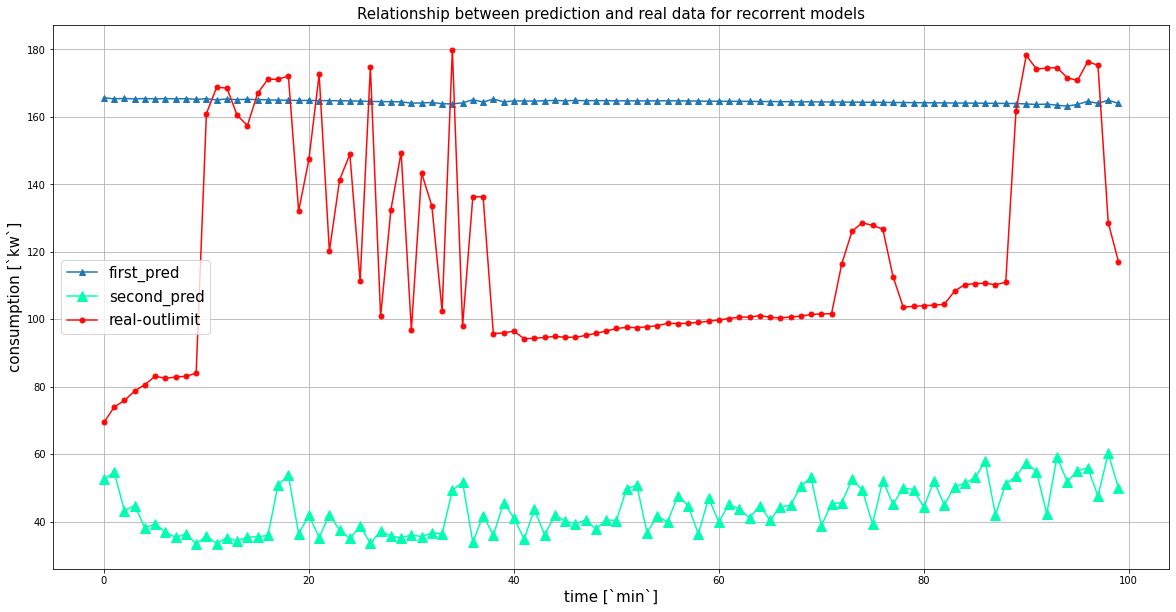

In [62]:
plt.figure(figsize=(20, 10))
plt.title(f'Relationship between prediction and real data for recorrent models', fontsize=15)
plt.plot(descaled_first_attempt_pred, '^', ls='-',label='first_pred')
plt.plot(descaled_second_attempt_pred, '^', ms = 10, ls = '-', c = '#00FFB2',label='second_pred')
plt.plot(descaled_first_attempt_label, '.', ms = 10, ls = '-', c = '#FF0808',label='real-outlimit')

plt.xlabel('time [`min`]', fontsize=15)
plt.ylabel('consumption [`kw`]', fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

In [ ]:
out_limit_pred

In [ ]:
forecasting_data

In [ ]:
forecasting_confer

In [ ]:
with open(f'etc/results/test/661_test_30_pca2/result_report.json') as json_file:
    data = json.load(json_file)
    json_file.close()

test_predictions_data = data 
new_prediction_data = []
for model in test_predictions_data:
    for prediction in model['predict']:
        prediction['model'] = model['model']
    new_prediction_data += model['predict']
complete_prediction_df = pd.DataFrame(new_prediction_data)
labels = np.array(complete_prediction_df[complete_prediction_df['model'] == 'LSTM'].label)

In [ ]:
descaled_label, descaled_out_limit_pred

In [ ]:
indexes = complete_prediction_df[complete_prediction_df['model'] == 'RNN'].index[-60:].to_list()
indexes[0], indexes[len(indexes) - 1]

In [ ]:
out_limit_indexes = np.arange(indexes[len(indexes) - 1], indexes[len(indexes) - 1] + 15, 1)
out_limit_indexes

In [ ]:
descaled_test = descale(descaler, forecasting_confer['consumption'].values)
descaled_test

In [ ]:
plt.figure(figsize=(20, 10))
plt.title(f'Relationship between prediction and real data for recorrent models', fontsize=15)
plt.plot(indexes, descaled_label[-60:], '^', ls='-',label='real')
plt.plot(indexes, descaled_lstm_prediction[-60:], '.', ms = 10, ls = '-', c = '#00FFB2',label='LSTM')
plt.plot(out_limit_indexes, descaled_out_limit_pred, '.', ms = 10, ls = '-', c = '#FF0808',label='out-limit')
plt.plot(out_limit_indexes, descaled_test[:15], '.', ms = 10, ls = '-', c = '#1BFF08',label='out-limit-real')



# plt.plot(output, 'm--', label='predictions')

plt.xlabel('time [`min`]', fontsize=15)
plt.ylabel('consumption [`kw`]', fontsize=15)
plt.legend(fontsize=15)
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.eps', dpi=600, bbox_inches='tight')
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.svg', dpi=600, bbox_inches='tight')
plt.grid()
plt.show()